In [56]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import random as rand
%matplotlib inline
import matplotlib.pyplot as plt 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is : {device}")

Device is : cuda


In [57]:
import random

def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return

In [58]:

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])



trainset = datasets.SVHN('data', split="train", download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = datasets.SVHN('data', split="test", download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=6128, shuffle=True)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [59]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
# from tqdm import tqdm



class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 10)
        
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params


In [60]:


from tqdm import tqdm
import optuna
def objective (trial):


  model = Classifier()
  model = model.to(device)
  criterion = nn.NLLLoss().to(device)

  lr = trial.suggest_loguniform("lr", 5e-4, 1e-3)
  print(lr)
  epochs = trial.suggest_int("epochs", 15, 30)
  print(epochs)


  optimizer = optim.Adam(model.parameters(), lr= lr)

  steps = 0

  cm = [ [ 0 for i in range(10) ] for j in range(10) ]


  train_losses, test_losses = [], []
  train_acc, test_acc =[],[]
  Norm_grad = [] 
  progress_bar = tqdm(range(epochs), total=epochs)       
  for e in progress_bar:

      running_loss = 0
      accuracy2 = 0
      total_norm=0
      for images, labels in trainloader:
          images= images.to(device)
          labels = labels.to(device)
        
          optimizer.zero_grad()
          log_ps = model(images)        
          loss = criterion(log_ps, labels)
          loss.backward()
        
          optimizer.step()
          with torch.no_grad(): 
            model.eval()
            log_ps2 = log_ps.clone().detach()               
            ps2 = torch.exp(log_ps2)
            top_p2, top_class2 = ps2.topk(1, dim=1)
            equals2 = top_class2 == labels.view(*top_class2.shape)
            accuracy2 += torch.mean(equals2.type(torch.FloatTensor))
            norm=0
            for p in model.parameters():
                param_norm = p.grad.data.norm(2)
                norm += param_norm.item() ** 2
            total_norm += norm ** (1. / 2)      


          model.train()        
          running_loss += loss.item()

      else:
          test_loss = 0
          accuracy = 0
        
          # Turn off gradients for validation, saves memory and computations
          with torch.no_grad():
            
              model.eval()
              for images, labels in testloader:
                  images= images.to(device)
                  labels = labels.to(device)             
                  log_ps = model(images)
                  test_loss += criterion(log_ps, labels)
                
                  ps = torch.exp(log_ps)
                  top_p, top_class = ps.topk(1, dim=1)
                  equals = top_class == labels.view(*top_class.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor))
                  cm += confusion_matrix(labels.view(*top_class.shape).cpu(), top_class.cpu())
                

        
          model.train()
        
          train_losses.append(running_loss/len(trainloader))
          test_losses.append(test_loss/len(testloader))
          train_acc.append(accuracy2/len(trainloader))
          test_acc.append(accuracy/len(testloader))
          Norm_grad.append(total_norm)
        

          # print("Epoch: {}/{}.. ".format(e+1, epochs),
          #     "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          #     "Train Accuracy: {:.3f}".format(accuracy2/len(trainloader)),
          #     "Test Loss: {:.3f}.. ".format(test_losses[-1]),
          #     "Test Accuracy: {:.3f}".format(accuracy/len(testloader)),
          #     "Norm: {:.3f}".format(total_norm))
  # print(cm)
        

  return (accuracy/len(testloader))

In [61]:
study = optuna.create_study(direction="maximize")
study.optimize(objective ,n_trials=5)

pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))
fig = optuna.visualization.plot_contour(study, params=["lr", "epochs"])
fig.show()

[I 2021-11-15 18:27:06,053] A new study created in memory with name: no-name-ecf70314-9afc-46b4-b10d-b24d45b6a2ab


0.0007938182842653259
22


100%|██████████| 22/22 [07:48<00:00, 21.29s/it]
[I 2021-11-15 18:34:54,498] Trial 0 finished with value: 0.7104084491729736 and parameters: {'lr': 0.0007938182842653259, 'epochs': 22}. Best is trial 0 with value: 0.7104084491729736.


0.0008230964698018576
17


100%|██████████| 17/17 [05:52<00:00, 20.73s/it]
[I 2021-11-15 18:40:46,951] Trial 1 finished with value: 0.7287731766700745 and parameters: {'lr': 0.0008230964698018576, 'epochs': 17}. Best is trial 1 with value: 0.7287731766700745.


0.0006082932321260644
21


100%|██████████| 21/21 [07:19<00:00, 20.95s/it]
[I 2021-11-15 18:48:06,956] Trial 2 finished with value: 0.7620413303375244 and parameters: {'lr': 0.0006082932321260644, 'epochs': 21}. Best is trial 2 with value: 0.7620413303375244.


0.0007567986033074303
23


100%|██████████| 23/23 [08:02<00:00, 20.99s/it]
[I 2021-11-15 18:56:09,780] Trial 3 finished with value: 0.7160928249359131 and parameters: {'lr': 0.0007567986033074303, 'epochs': 23}. Best is trial 2 with value: 0.7620413303375244.


0.000677358433087434
18


100%|██████████| 18/18 [06:16<00:00, 20.93s/it]
[I 2021-11-15 19:02:26,603] Trial 4 finished with value: 0.6292867660522461 and parameters: {'lr': 0.000677358433087434, 'epochs': 18}. Best is trial 2 with value: 0.7620413303375244.


Study statistics: 
  Number of finished trials:  5
  Number of pruned trials:  0
  Number of complete trials:  5
Best trial:
  Value:  0.7620413303375244
  Params: 
    lr: 0.0006082932321260644
    epochs: 21


In [62]:
print(study.best_params)

{'lr': 0.0006082932321260644, 'epochs': 21}


In [63]:
model = Classifier()
model = model.to(device)

criterion = nn.NLLLoss().to(device)
lr = study.best_params['lr']
optimizer = optim.Adam(model.parameters(), lr= lr)

epochs = study.best_params['epochs']
steps = 0
cm = [ [ 0 for i in range(10) ] for j in range(10) ]


train_losses, test_losses = [], []
train_acc, test_acc =[],[]
Norm_grad = []        
for e in range(epochs):

    running_loss = 0
    accuracy2 = 0
    total_norm=0
    for images, labels in trainloader:
        images= images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        log_ps = model(images)        
        loss = criterion(log_ps, labels)
        loss.backward()
        
        optimizer.step()
        with torch.no_grad(): 
          model.eval()
          log_ps2 = log_ps.clone().detach()               
          ps2 = torch.exp(log_ps2)
          top_p2, top_class2 = ps2.topk(1, dim=1)
          equals2 = top_class2 == labels.view(*top_class2.shape)
          accuracy2 += torch.mean(equals2.type(torch.FloatTensor))
          norm=0
          for p in model.parameters():
              param_norm = p.grad.data.norm(2)
              norm += param_norm.item() ** 2
          total_norm += norm ** (1. / 2)      


        model.train()        
        running_loss += loss.item()

    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            
            model.eval()
            for images, labels in testloader:
                images= images.to(device)
                labels = labels.to(device)             
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                cm += confusion_matrix(labels.view(*top_class.shape).cpu(), top_class.cpu())
                

        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        train_acc.append(accuracy2/len(trainloader))
        test_acc.append(accuracy/len(testloader))
        Norm_grad.append(total_norm)
        

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Train Accuracy: {:.3f}".format(accuracy2/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)),
              "Norm: {:.3f}".format(total_norm))
# print(cm)
        


Epoch: 1/21..  Training Loss: 2.209..  Train Accuracy: 0.198 Test Loss: 1.934..  Test Accuracy: 0.322 Norm: 309.094
Epoch: 2/21..  Training Loss: 1.639..  Train Accuracy: 0.430 Test Loss: 1.547..  Test Accuracy: 0.480 Norm: 1422.490
Epoch: 3/21..  Training Loss: 1.360..  Train Accuracy: 0.548 Test Loss: 1.345..  Test Accuracy: 0.566 Norm: 1626.018
Epoch: 4/21..  Training Loss: 1.205..  Train Accuracy: 0.612 Test Loss: 1.318..  Test Accuracy: 0.576 Norm: 1858.460
Epoch: 5/21..  Training Loss: 1.122..  Train Accuracy: 0.645 Test Loss: 1.215..  Test Accuracy: 0.619 Norm: 1860.983
Epoch: 6/21..  Training Loss: 1.060..  Train Accuracy: 0.667 Test Loss: 1.194..  Test Accuracy: 0.634 Norm: 1862.232
Epoch: 7/21..  Training Loss: 1.012..  Train Accuracy: 0.683 Test Loss: 1.138..  Test Accuracy: 0.649 Norm: 1840.678
Epoch: 8/21..  Training Loss: 0.969..  Train Accuracy: 0.698 Test Loss: 1.131..  Test Accuracy: 0.654 Norm: 1840.054
Epoch: 9/21..  Training Loss: 0.936..  Train Accuracy: 0.710 Test

In [64]:
import numpy as np
def view_classify(img, ps, version="SVHN"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 32, 32).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "SVNH":
        ax2.set_yticklabels(np.arange(10))

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

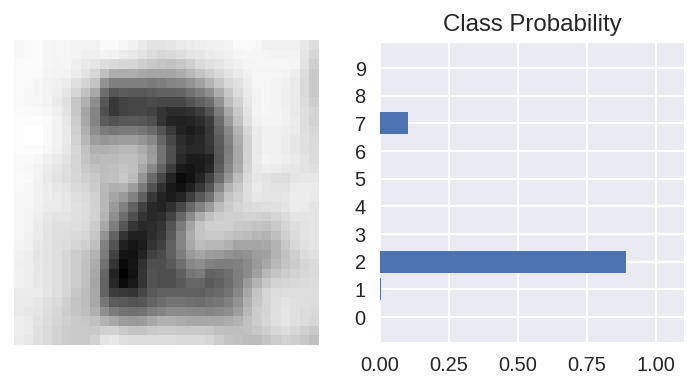

In [75]:

model = model.cpu()
model.eval()


dataiter = iter(testloader)
images, labels = dataiter.next()

img = images[0]

img = img.view(1, 3072)


with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)
view_classify(img.view(3, 32, 32), ps, version='SVNH')


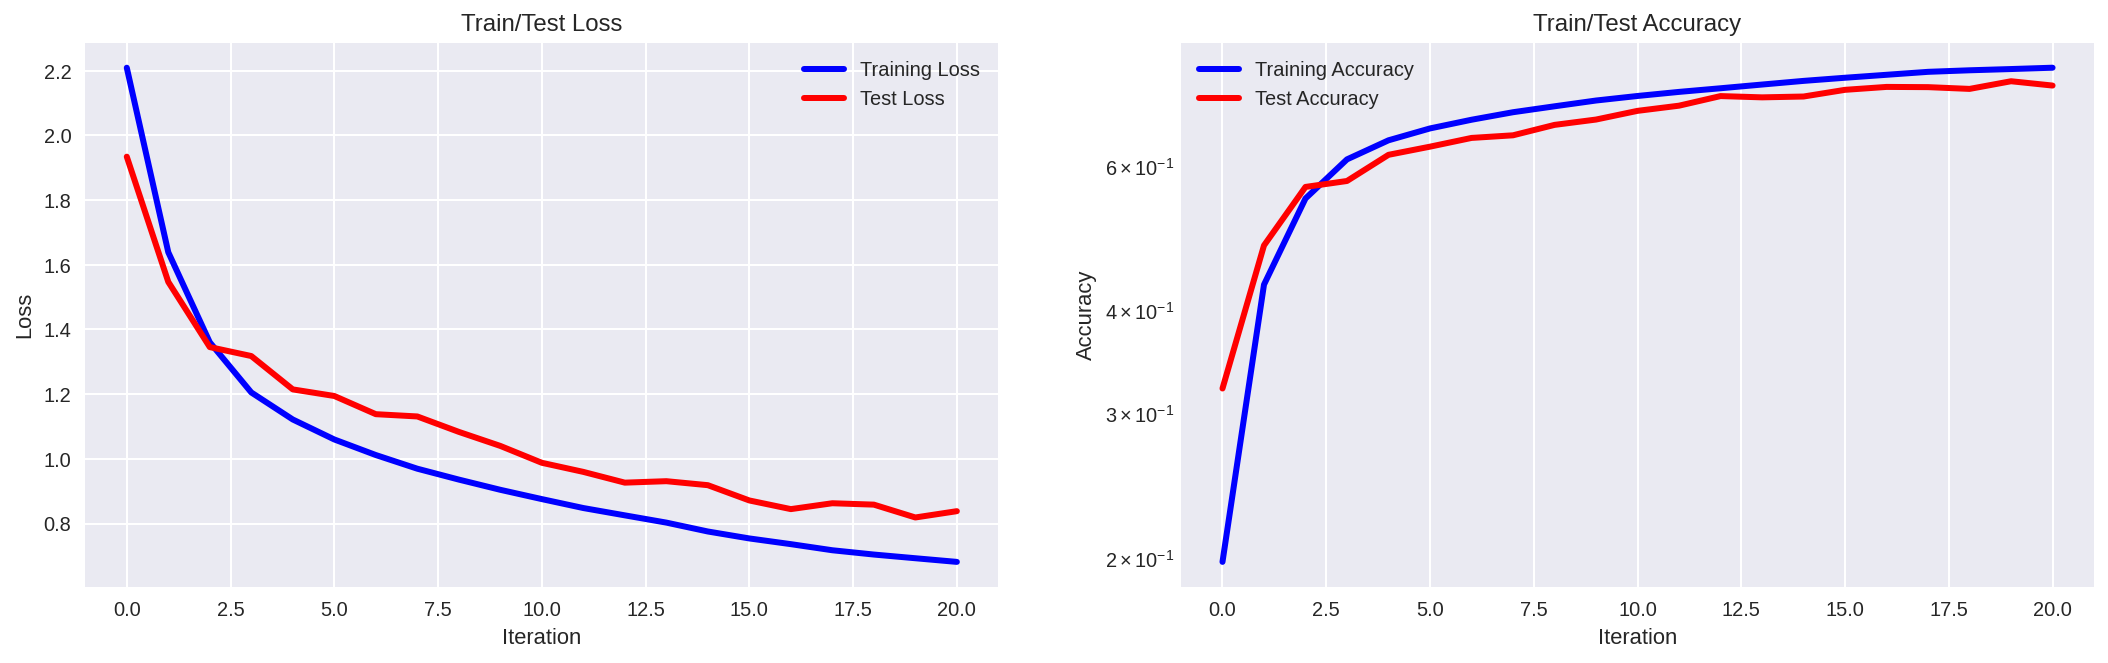

In [66]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt



plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,5)


ax[0].plot(train_losses, c="blue", label="Training Loss", linewidth=3)
ax[0].plot(test_losses, c="red", label="Test Loss", linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")
ax[0].set_title("Train/Test Loss")

ax[1].plot(train_acc, c="blue", label="Training Accuracy", linewidth=3)
ax[1].plot(test_acc, c="red", label="Test Accuracy", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Accuracy")
ax[1].set_yscale("log")
ax[1].set_title("Train/Test Accuracy")

plt.show()

Confusion Matrix : 

[[21684  2464  2061  2285  1489  1134  2064  1002   755  1686]
 [ 1792 87678  4378  3762  3681  1106   998  2112   538  1034]
 [  855  6135 64657  4457  2775  1159  1277  3728   814  1272]
 [  762  7597  5463 34950  1622  4516   688  1468   925  2531]
 [  856  3661  1751  1236 40998   716  1873   390   545   957]
 [  996  3324  1888  4836  2197 28615  3357   590  2227  2034]
 [ 2335  2235  1779  1363  3705  2250 25352   427  1599   472]
 [  385  4900  6769  1508   404   515   646 26561   141   570]
 [ 2313  2494  1240  1564  2214  2295  5743   283 14992  1722]
 [ 3023  3026  2213  2087  1291  1728   916   665   819 17727]]


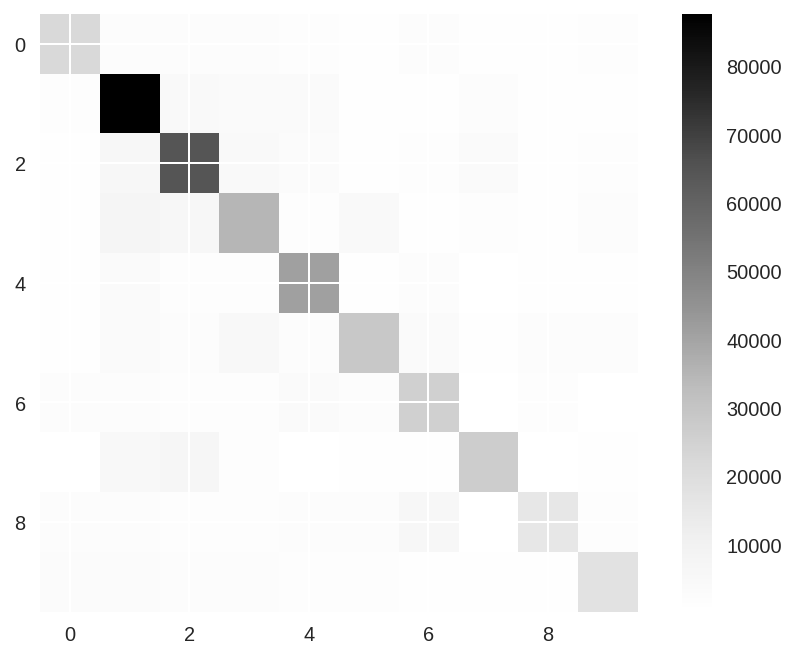

In [67]:
print("Confusion Matrix : \n")
print(cm)

plt.imshow(cm)
plt.colorbar()
plt.show()

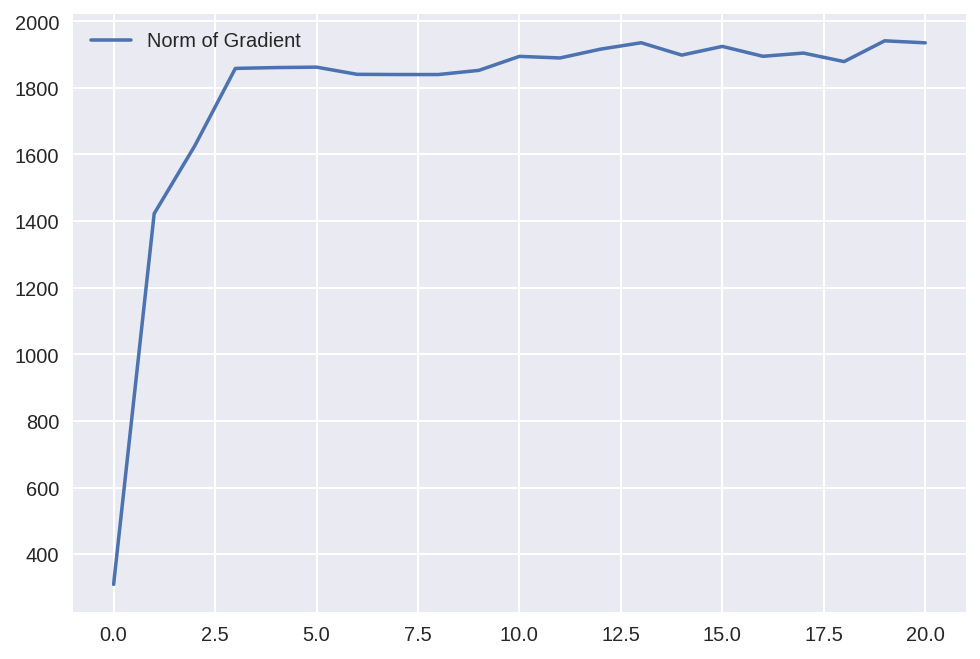

In [68]:
plt.plot(Norm_grad, label='Norm of Gradient')

plt.legend(frameon=False)